# Import libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import folium
from folium import plugins
from folium.plugins import HeatMap

from shapely.geometry import Point
import geopandas as gpd

import os

## Import bike data from Final Data Files

In [11]:
# Function to import bike_data_2019.csv with try and except
def import_bike_data():
    """
    Read all CSV files in a directory and return them as a list of Pandas dataframes.
    """
    try:
        bike_data_2019 = pd.read_csv('./Final Data Files/bike_data_2019.csv')
        print("File bike_data_2019.csv successfully read.")
    except Exception as e:
        print(f"Error reading file bike_data_2019.csv: {e}")
    
    return bike_data_2019

In [12]:
bike_data = import_bike_data()
bike_data.shape

File bike_data_2019.csv successfully read.


(10310063, 23)

In [22]:
bike_data.shape

(9954256, 23)

### Check the years in the data

In [5]:
# print distinct start_year values
print("Distinct start_year values: ", bike_data['start_year'].unique())

Distinct start_year values:  [2019]


## Import BikePoints from Final Data Files

In [6]:
# Function to import bike_points.csv with try and except
def import_bike_points():
    """
    Read all CSV files in a directory and return them as a list of Pandas dataframes.
    """
    try:
        bike_points = pd.read_csv('./Final Data Files/bike_points.csv')
        print("File bike_points.csv successfully read.")
    except Exception as e:
        print(f"Error reading file bike_points.csv: {e}")
    
    return bike_points

In [7]:
bike_points = import_bike_points()
bike_points.shape

File bike_points.csv successfully read.


(796, 9)

# Data check functions

### Check columns data types and counts

In [8]:
# Function that receives a dataframe and returns datat types and count for each column
def get_data_types(df):
    """
    Returns the data types and count for each column in a dataframe.
    """
    data_types = pd.DataFrame(df.dtypes, columns=['Data Type'])
    data_types['Count'] = df.count()
    data_types['Null Count'] = df.isnull().sum()
    return data_types

In [9]:
get_data_types(bike_data)

,Data Type,Count,Null Count
rental_id,int64,10310063,0
duration,int64,10310063,0
bike_id,int64,10310063,0
end_date,object,10310063,0
endstation_id,int64,10310063,0
endstation_name,object,10310063,0
start_date,object,10310063,0
startstation_id,int64,10310063,0
startstation_name,object,10310063,0
start_timestamp,object,10310063,0


In [47]:
get_data_types(bike_points)

,Data Type,Count,Null Count
bike_station_name,object,796,0
station_longitude,float64,796,0
station_latitude,float64,796,0
number_of_bikes,int64,796,0
number_empty_docks,int64,796,0
number_of_docks,int64,796,0
number_standard_bikes,int64,796,0
number_ebikes,int64,796,0
bike_station_id,int64,796,0


### Check dates

In [15]:
# Function to check the dates in the bike_data_2019.csv file
def check_dates(df):
    """
    Returns a string with count of the number of rows that have the start_timestamp after the end_timestamp. 
    Also returns the count of the number of rows that have the start day and end day not equal.
    """
    # check the number of rows that have the start_timestamp after the end_timestamp
    start_after_end = df[df['start_timestamp'] > df['end_timestamp']].shape[0]

    # check the number of rows that have the start day and end day not equal
    start_day_not_equal_end_day = df[df['start_day'] != df['end_day']].shape[0]
    
    # check if there is any missing date in the dataframe
    # Create a sequence of all dates in the range of the data
    date_range = pd.date_range(start=df['start_date'].min(), end=df['start_date'].max(), freq='D')

    # Get the list of dates in the data
    data_dates = df['start_date'].unique()

    # Find the missing dates
    missing_dates = date_range[~date_range.isin(data_dates)]
    
    # check if there is any duration that is less than 0
    negative_duration = df[df['duration'] < 0].shape[0]
    
    # check if there is any duration that is equal to 0
    duration_equal_to_0 = df[df['duration'] == 0].shape[0]
    
    # print the results
    print(f'There are {start_after_end} rows that have the start_timestamp after the end_timestamp.')
    print(f'There are {start_day_not_equal_end_day} rows that have the start day and end day not equal.')
    print(f'There are {len(missing_dates)} missing dates in the dataframe.')
    print(f'There are {negative_duration} rows that have a duration less than 0.')
    print(f'There are {duration_equal_to_0} rows that have a duration equal to 0.')    
    

In [16]:
check_dates(bike_data)

There are 0 rows that have the start_timestamp after the end_timestamp.
There are 39536 rows that have the start day and end day not equal.
There are 0 missing dates in the dataframe.
There are 0 rows that have a duration less than 0.
There are 0 rows that have a duration equal to 0.


### Check missing stations

#### 2 issues: 
#### 1- Missing IDs - missing from bike_data {672, 482, 391, 840, 841, 842, 844, 525, 845, 846, 847, 849, 850, 147, 851, 852}
#### 2- IDS with different station names 290 = St Mary's Hospital, Paddington 725 = Walworth Square, Walworth 818 = Westminster Pier, Westminster 832 = Ferndale Road, Brixton

In [17]:
# Function to remove start/end station ids that are not in the bike_data dataframe
def remove_invalid_station_ids(df, bike_points):
    """
    Returns a dataframe with the rows that have valid start_station_id and end_station_id.
    """
    # get the list of valid station ids
    valid_station_ids = bike_points['bike_station_id'].unique()
    
    # filter the dataframe by the valid station ids
    df = df[df['startstation_id'].isin(valid_station_ids)]
    df = df[df['endstation_id'].isin(valid_station_ids)]
    
    return df


In [18]:
bike_data = remove_invalid_station_ids(bike_data, bike_points)


In [19]:
# Function to change start/end station names to bike_points station names
def change_station_names(df, bike_points):
    """
    Returns a dataframe with the start_station_name and end_station_name columns changed to the bike_points station names.
    """
    # change the start_station_name and end_station_name columns to the bike_points station names
    df['startstation_name'] = df['startstation_id'].map(bike_points.set_index('bike_station_id')['bike_station_name'])
    df['endstation_name'] = df['endstation_id'].map(bike_points.set_index('bike_station_id')['bike_station_name'])
    
    return df

In [20]:
bike_data = change_station_names(bike_data, bike_points)

In [21]:
# check if there are any missing ids from bike_data not in bike_points
missing_start_ids = bike_data[~bike_data['startstation_id'].isin(bike_points['bike_station_id'])]
missing_end_ids = bike_data[~bike_data['endstation_id'].isin(bike_points['bike_station_id'])]

print(f'There are {missing_start_ids.shape[0]} missing start ids from bike_data not in bike_points.')
print(f'There are {missing_end_ids.shape[0]} missing end ids from bike_data not in bike_points.')

There are 0 missing start ids from bike_data not in bike_points.
There are 0 missing end ids from bike_data not in bike_points.


In [23]:
# check if number_of_bikes + number_empty_docks = number_of_docks
print(bike_points['number_of_docks'].equals(bike_points['number_of_bikes'] + bike_points['number_empty_docks']))
print(bike_points['number_of_bikes'].equals(bike_points['number_standard_bikes'] + bike_points['number_ebikes']))

# total number of standard bikes
print(bike_points['number_standard_bikes'].sum())

# total number of ebikes
print(bike_points['number_ebikes'].sum())

# total number of docks
print(bike_points['number_of_docks'].sum())

# total number of bikes
print(bike_points['number_of_bikes'].sum())

# number of empty docks
print(bike_points['number_empty_docks'].sum())

# bike_points.head()

True
True
10273
462
20993
10735
10258


# Statistics

In [73]:
# Function that takes a dataframe and returns the unique values for each categorical column
def get_unique_values(df):
    """
    Returns the unique values for each categorical column in a dataframe.
    """
    unique_values = pd.DataFrame(df.nunique(), columns=['Unique Values'])
    return unique_values

In [74]:
get_unique_values(bike_data)

,Unique Values
rental_id,9954256
duration,3126
bike_id,12943
end_date,365
endstation_id,780
endstation_name,780
start_date,365
startstation_id,780
startstation_name,780
start_timestamp,484123


In [75]:
get_unique_values(bike_points)

,Unique Values
bike_station_name,796
station_longitude,793
station_latitude,795
number_of_bikes,45
number_empty_docks,46
number_of_docks,48
number_standard_bikes,45
number_ebikes,9
bike_station_id,796


## Calculate summary statisitics for bike points (Stations)

In [24]:
# Function that sum the total number of standard bikes, ebikes, number of docks, and number of empty docks
def sum_bikes_docks(df):
    """
    Sum the total number of standard bikes, ebikes, number of docks, and number of empty docks.
    """
    total_number_of_bikes = df['number_of_bikes'].sum()
    total_standard_bikes = df['number_standard_bikes'].sum()
    total_ebikes = df['number_ebikes'].sum()
    total_number_of_docks = df['number_of_docks'].sum()
    total_number_empty_docks = df['number_empty_docks'].sum()
    
    print(f'The total number of bikes is {total_number_of_bikes}.')
    print(f'The total number of standard bikes is {total_standard_bikes}.')
    print(f'The total number of ebikes is {total_ebikes}.')
    print(f'The total number of docks is {total_number_of_docks}.')
    print(f'The total number of empty docks is {total_number_empty_docks}.')
    

In [25]:
sum_bikes_docks(bike_points)

The total number of bikes is 10735.
The total number of standard bikes is 10273.
The total number of ebikes is 462.
The total number of docks is 20993.
The total number of empty docks is 10258.


# Plot analysis

## Bike points

<Axes: title={'center': 'Boxplot for the number of bikes, empty docks, docks, ebikes, and standard bikes'}>

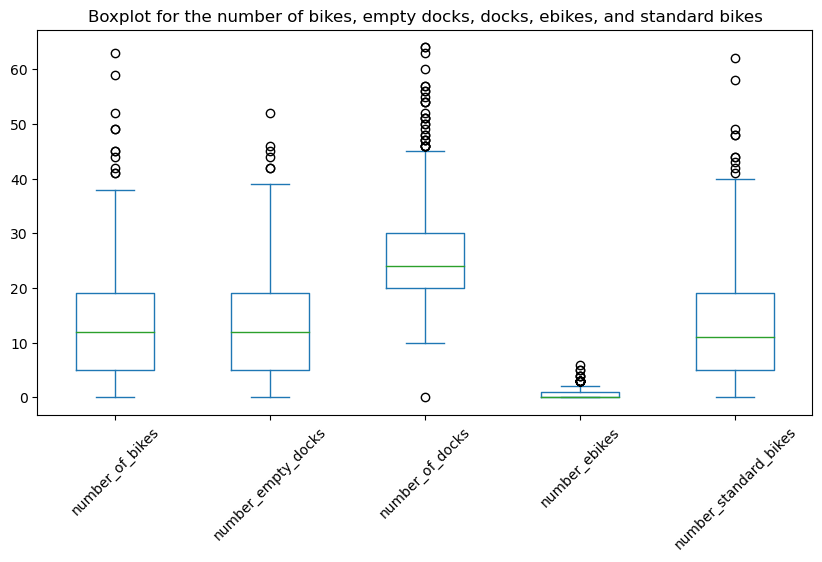

In [152]:
# plot boxplot for nbBikes, nbEmptyDocks, nbDocks, nbEBikes, nbStandardBikes
bike_points[['number_of_bikes', 'number_empty_docks', 'number_of_docks', 'number_ebikes', 'number_standard_bikes']].plot(kind='box', figsize=(10, 5), title='Boxplot for the number of bikes, empty docks, docks, ebikes, and standard bikes', rot=45)

<Axes: title={'center': 'Stations with the highest number of bikes'}, xlabel='bike_station_name'>

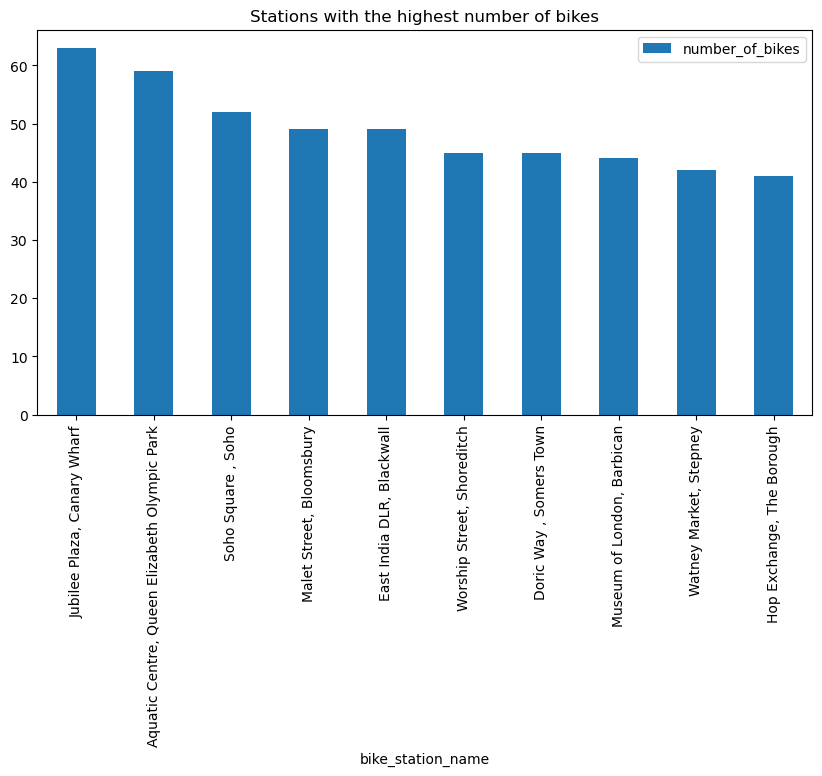

In [153]:
# plot stations with the highest number of bikes
bike_points.sort_values(by='number_of_bikes', ascending=False).head(10).plot(kind='bar', x='bike_station_name', y='number_of_bikes', figsize=(10, 5), title='Stations with the highest number of bikes')

<Axes: title={'center': 'Stations with the highest number of empty docks'}, xlabel='bike_station_name'>

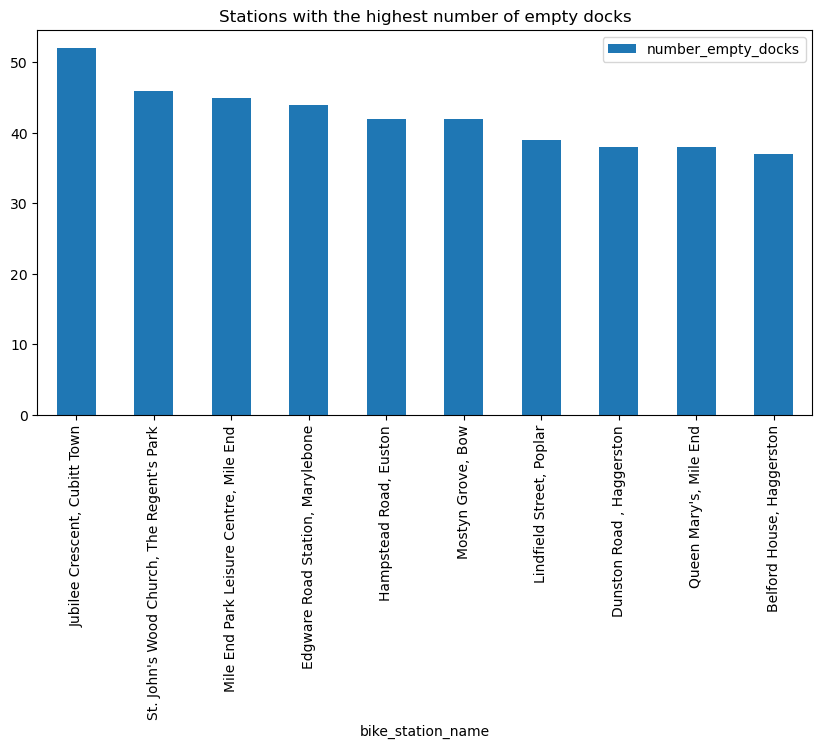

In [154]:
# plot stations with the highest number of empty docks
bike_points.sort_values(by='number_empty_docks', ascending=False).head(10).plot(kind='bar', x='bike_station_name', y='number_empty_docks', figsize=(10, 5), title='Stations with the highest number of empty docks')

In [38]:
# Create a map object
map = folium.Map(location=[51.5077736, -0.1277052], zoom_start=12)

# Add a marker for each station using circle markers
for i in range(0, len(bike_points)):
    folium.CircleMarker(
        location=[bike_points.iloc[i]['station_latitude'], bike_points.iloc[i]['station_longitude']],
        radius=5,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map)
    
# Display the map
map

In [ ]:
# get the longitude and latitude of theses station names from bike_points
station_location = bike_points[bike_points['bike_station_name'].isin(bike_data_2019_grouped_station.index[:50])]

station_location

,bike_point_id,bike_station_name,station_longitude,station_latitude,number_of_bikes,number_empty_docks,number_of_docks,number_standard_bikes,number_ebikes
13,BikePoints_14,"Belgrove Street , King's Cross",-0.123616,51.529943,30,18,48,29,1
37,BikePoints_39,"Shoreditch High Street, Shoreditch",-0.078130,51.526377,38,3,41,38,0
44,BikePoints_46,"Nesham Street, Wapping",-0.066910,51.507131,12,4,16,11,1
53,BikePoints_55,"Finsbury Circus, Liverpool Street",-0.086685,51.517075,32,1,33,32,0
63,BikePoints_66,"Holborn Circus, Holborn",-0.108657,51.517950,33,7,40,33,0
68,BikePoints_71,"Newgate Street , St. Paul's",-0.098850,51.515418,23,11,34,23,0
70,BikePoints_73,"Old Street Station, St. Luke's",-0.089659,51.525480,24,5,29,21,3
71,BikePoints_74,"Vauxhall Cross, Vauxhall",-0.124469,51.485917,17,0,17,17,0
98,BikePoints_101,"Queen Street 1, Bank",-0.092940,51.511553,10,12,22,9,1
101,BikePoints_104,"Crosswall, Tower",-0.077121,51.511594,30,4,34,27,3


In [ ]:
# plot a map for all stations and color the top 5 stations with the highest number of rides
# create a map of London with the stations
map_london = folium.Map(location=[51.5074, 0.1278], zoom_start=12)

# add markers to map
for lat, lng, station_name in zip(station_location['station_latitude'], station_location['station_longitude'], station_location['bike_station_name']):
    label = '{}'.format(station_name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)
    
map_london

# Bike data

<Axes: title={'center': 'Average trip duration by day of the week'}, xlabel='start_day_of_week'>

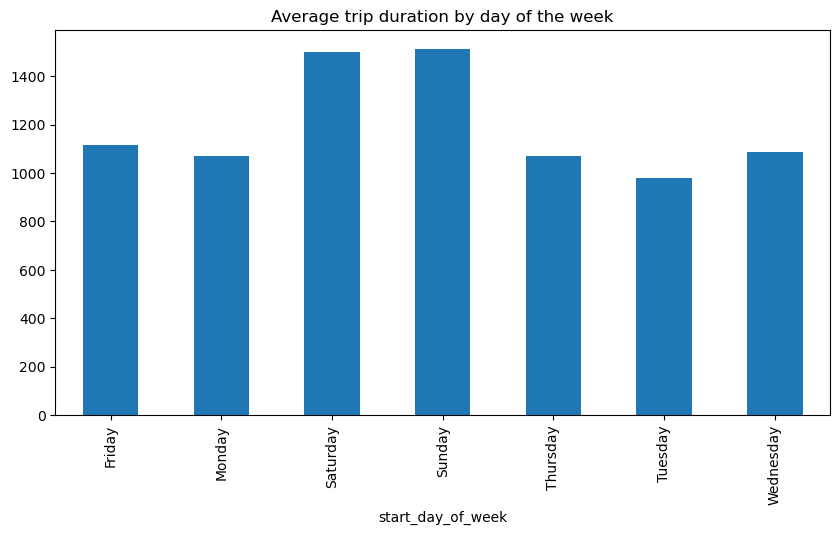

In [32]:
# plot trip duration by day of the week 
bike_data.groupby('start_day_of_week')['duration'].mean().plot(kind='bar', figsize=(10, 5), title='Average trip duration by day of the week')


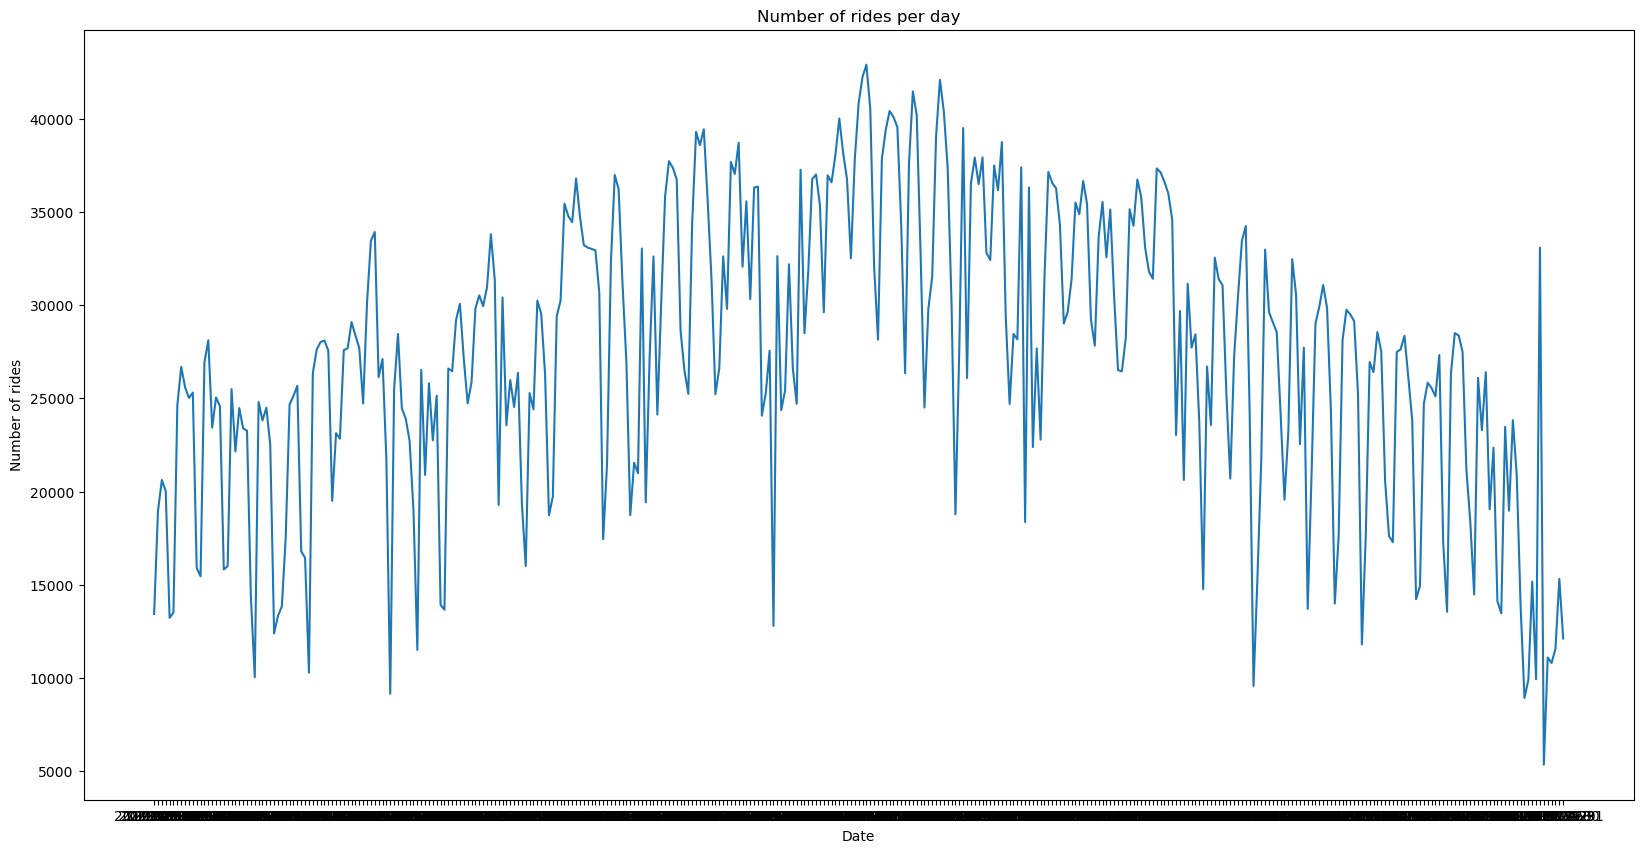

In [31]:
# Group the data by Start Date and count the number of rides per day with 1 column
bike_data_2019_grouped_date = bike_data.groupby('start_date').count()
bike_data_2019_grouped_date = bike_data_2019_grouped_date[['rental_id']]
bike_data_2019_grouped_date = bike_data_2019_grouped_date.rename(columns={'rental_id': 'rides_per_day'})

# Plot the number of rides per day
plt.figure(figsize=(20,10))
plt.plot(bike_data_2019_grouped_date.index, bike_data_2019_grouped_date['rides_per_day'])
plt.xlabel('Date')
plt.ylabel('Number of rides')
plt.title('Number of rides per day')
plt.show()

<Axes: title={'center': 'Number of rides per day of week'}, xlabel='start_day_of_week'>

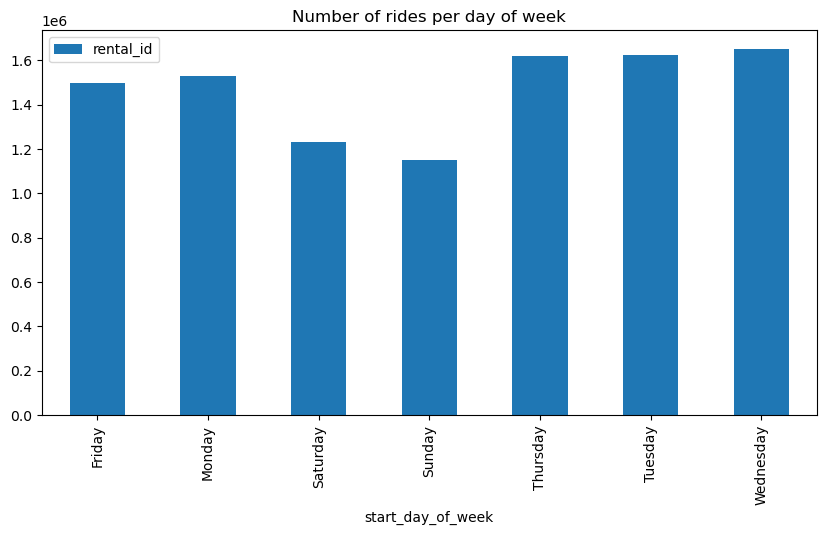

In [22]:
# plot the number of rides by grouping number of rides per day of week
bike_data_2019_grouped_dayofweek = bike_data.groupby('start_day_of_week').count()
bike_data_2019_grouped_dayofweek = bike_data_2019_grouped_dayofweek[['rental_id']]

# plot the number of rides per day of week
bike_data_2019_grouped_dayofweek.plot(kind='bar', figsize=(10, 5), title='Number of rides per day of week')



In [23]:
# print the number of rides per day of week
bike_data_2019_grouped_dayofweek

,rental_id
start_day_of_week,
Friday,1498069
Monday,1530343
Saturday,1231833
Sunday,1150968
Thursday,1621535
Tuesday,1624374
Wednesday,1652941


<Axes: title={'center': 'Number of rides per hour of day'}, xlabel='start_hour'>

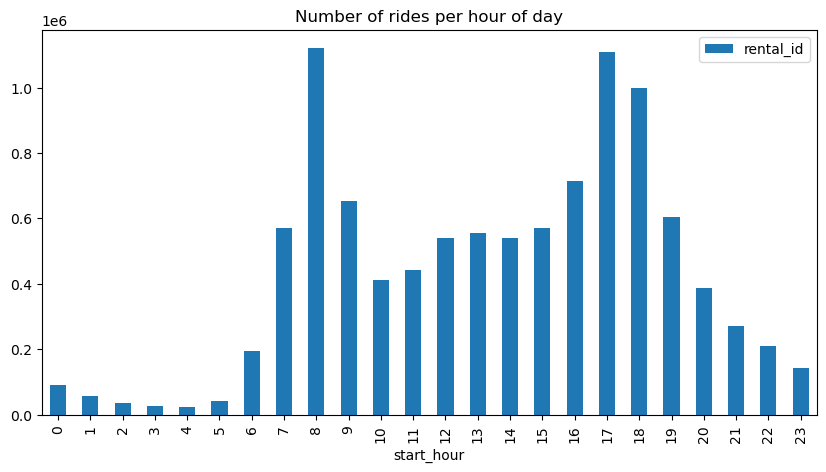

In [26]:
# plot the number of rides by grouping number of rides per hour of day
bike_data_2019_grouped_hourofday = bike_data_2019.groupby('start_hour').count()
bike_data_2019_grouped_hourofday = bike_data_2019_grouped_hourofday[['rental_id']]

# plot the number of rides per hour of day
bike_data_2019_grouped_hourofday.plot(kind='bar', figsize=(10, 5), title='Number of rides per hour of day')

In [27]:
# print the number of rides per hour of day
bike_data_2019_grouped_hourofday

,rental_id
start_hour,
0,89855
1,56870
2,35995
3,25724
4,23889
5,41922
6,193766
7,572257
8,1120184


<Axes: title={'center': 'Number of rides per month'}, xlabel='start_month'>

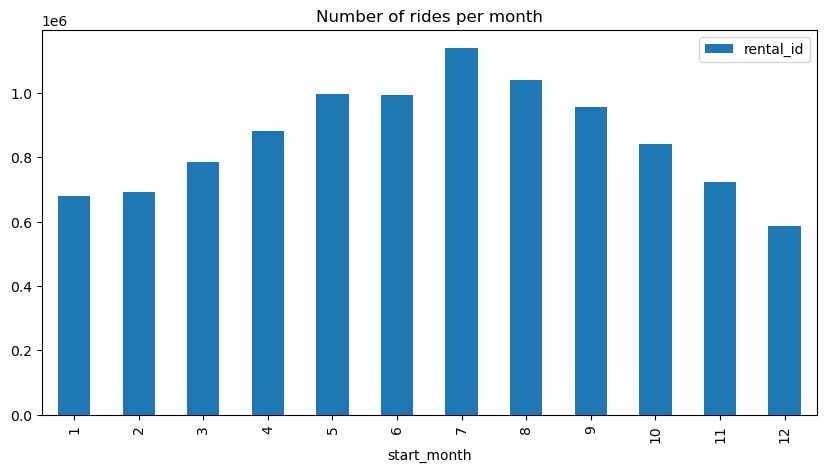

In [24]:
# plot the number of rides by grouping number of rides per month
bike_data_2019_grouped_month = bike_data_2019.groupby('start_month').count()
bike_data_2019_grouped_month = bike_data_2019_grouped_month[['rental_id']]

# plot the number of rides per month
bike_data_2019_grouped_month.plot(kind='bar', figsize=(10, 5), title='Number of rides per month')

In [25]:
# print number of rides per month
bike_data_2019_grouped_month

,rental_id
start_month,
1,679520
2,691770
3,784410
4,880513
5,995968
6,993747
7,1138703
8,1041301
9,955206


In [171]:
# print the highest number of rides per day of the week, per hour of the day and per month, and hightest number of rides per hour per day of the week
# Sort the data at first
bike_data_2019_grouped_dayofweek = bike_data_2019_grouped_dayofweek.sort_values(by='rental_id', ascending=False)
bike_data_2019_grouped_hourofday = bike_data_2019_grouped_hourofday.sort_values(by='rental_id', ascending=False)
bike_data_2019_grouped_month = bike_data_2019_grouped_month.sort_values(by='rental_id', ascending=False)

# print the highest number of rides per day of the week
print(f'The highest number of rides per day of the week is {bike_data_2019_grouped_dayofweek.iloc[0, 0]} on {bike_data_2019_grouped_dayofweek.index[0]}.')
# print the highest number of rides per hour of the day
print(f'The highest number of rides per hour of the day is {bike_data_2019_grouped_hourofday.iloc[0, 0]} on {bike_data_2019_grouped_hourofday.index[0]} o\'clock.')
# print the highest number of rides per month
print(f'The highest number of rides per month is {bike_data_2019_grouped_month.iloc[0, 0]} in {bike_data_2019_grouped_month.index[0]}.')

print('-'*100)

# print the lowest number of rides per day of the week
print(f'The lowest number of rides per day of the week is {bike_data_2019_grouped_dayofweek.iloc[-1, 0]} on {bike_data_2019_grouped_dayofweek.index[-1]}.')
# print the lowest number of rides per hour of the day
print(f'The lowest number of rides per hour of the day is {bike_data_2019_grouped_hourofday.iloc[-1, 0]} on {bike_data_2019_grouped_hourofday.index[-1]} o\'clock.')
# print the lowest number of rides per month
print(f'The lowest number of rides per month is {bike_data_2019_grouped_month.iloc[-1, 0]} in {bike_data_2019_grouped_month.index[-1]}.')


The highest number of rides per day of the week is 1652941 on Wednesday.
The highest number of rides per hour of the day is 1120184 on 8 o'clock.
The highest number of rides per month is 1138703 in 7.
----------------------------------------------------------------------------------------------------
The lowest number of rides per day of the week is 1150968 on Sunday.
The lowest number of rides per hour of the day is 23889 on 4 o'clock.
The lowest number of rides per month is 585492 in 12.


In [30]:
# print the station names with highest and lowest number of rides and the number of rides
# Sort the data at first
bike_data_2019_grouped_station = bike_data_2019.groupby('startstation_name').count()
bike_data_2019_grouped_station = bike_data_2019_grouped_station[['rental_id']]
bike_data_2019_grouped_station = bike_data_2019_grouped_station.sort_values(by='rental_id', ascending=False)

# print the station name with the highest number of rides
print(f'The station name with the highest number of rides is {bike_data_2019_grouped_station.index[0]} with {bike_data_2019_grouped_station.iloc[0, 0]} rides.')
# print the station name with the lowest number of rides
print(f'The station name with the lowest number of rides is {bike_data_2019_grouped_station.index[-1]} with {bike_data_2019_grouped_station.iloc[-1, 0]} rides.')

# print the top 5 stations with the highest number of rides
print('-'*100)
print('The top 5 stations with the highest number of rides are:')
print(bike_data_2019_grouped_station.head())

The station name with the highest number of rides is Belgrove Street , King's Cross with 84578 rides.
The station name with the lowest number of rides is Thessaly Road North, Wandsworth Road with 7 rides.
----------------------------------------------------------------------------------------------------
The top 5 stations with the highest number of rides are:
                                rental_id
startstation_name                        
Belgrove Street , King's Cross      84578
Waterloo Station 3, Waterloo        77998
Hyde Park Corner, Hyde Park         71834
Waterloo Station 1, Waterloo        65950
Albert Gate, Hyde Park              55133


In [ ]:
# plot number of rides per bank holiday
bike_data_2019_grouped_bankholiday = bike_data_2019.groupby('bank_holiday').count()
bike_data_2019_grouped_bankholiday = bike_data_2019_grouped_bankholiday[['rental_id']]

# plot the number of rides per bank holiday
bike_data_2019_grouped_bankholiday.plot(kind='bar', figsize=(10, 5), title='Number of rides per bank holiday')

In [ ]:
#plot heatmap of january 2019 per day and hour
bike_data_2019_april = bike_data_2019[bike_data_2019['start_month'] == 4]
bike_data_2019_april_grouped_day_hour = bike_data_2019_april.groupby(['start_day', 'start_hour']).count()
bike_data_2019_april_grouped_day_hour = bike_data_2019_april_grouped_day_hour[['RentalID']]
bike_data_2019_april_grouped_day_hour = bike_data_2019_april_grouped_day_hour.rename(columns={'RentalID': 'rides_per_day_hour'})
bike_data_2019_april_grouped_day_hour = bike_data_2019_april_grouped_day_hour.reset_index()

# create a pivot table
bike_data_2019_january_grouped_day_hour_pivot = bike_data_2019_april_grouped_day_hour.pivot(index='start_day', columns='start_hour', values='rides_per_day_hour')

# plot the heatmap
plt.figure(figsize=(10,5))
sns.heatmap(bike_data_2019_january_grouped_day_hour_pivot, cmap='Blues')
plt.title('Number of rides per day and hour in January 2019')
plt.show()


## Extract few months of data by random sampling

In [45]:
# extract from data start and end months 2, 5,7,9,12
bike_data_2019_months = bike_data[bike_data['start_month'].isin([2, 5, 7, 9, 12]) & bike_data['end_month'].isin([2, 5, 7, 9, 12])]

In [46]:
bike_data_2019_months.shape

(4212136, 23)

In [48]:
# print number of peak hours variable for each month
bike_data_2019_months_grouped = bike_data_2019_months.groupby(['start_month'])['peak_hour'].value_counts()
bike_data_2019_months_grouped


start_month  peak_hour
2            1            363231
             0            304733
5            1            500447
             0            457011
7            1            580165
             0            517321
9            1            469745
             0            452162
12           1            285621
             0            281700
Name: peak_hour, dtype: int64

In [50]:
# print max date
print(f'The max date is {bike_data_2019_months["end_date"].max()}.')

# print min date
print(f'The min date is {bike_data_2019_months["end_date"].min()}.')



The max date is 2019-12-31.
The min date is 2019-02-01.


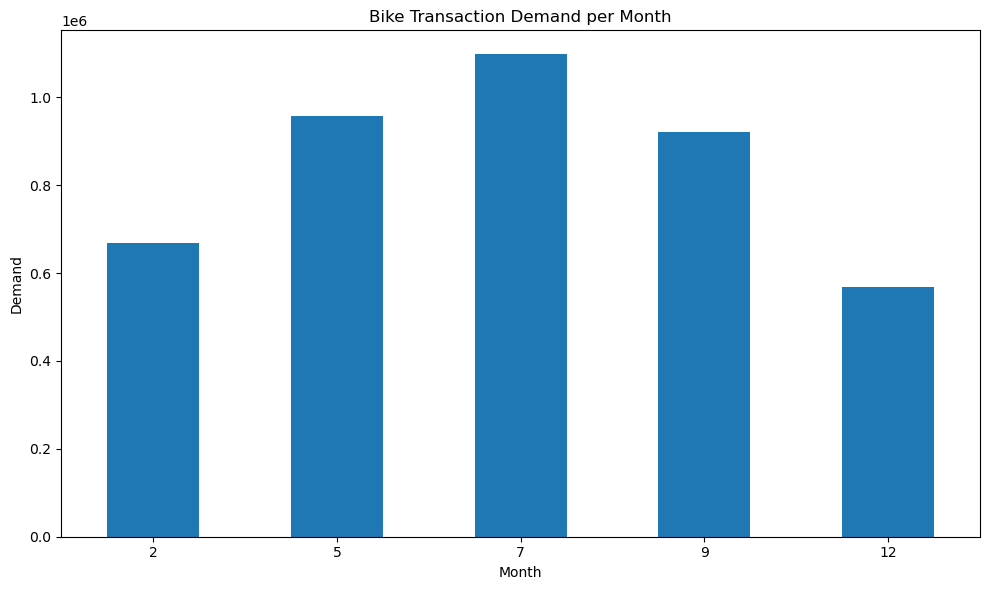

In [53]:
# Group the data by month and count the number of transactions
demand_per_month = bike_data_2019_months.groupby(bike_data_2019_months['start_month'])['rental_id'].count()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar chart
demand_per_month.plot(kind='bar')

# Customize the chart
plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Bike Transaction Demand per Month')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

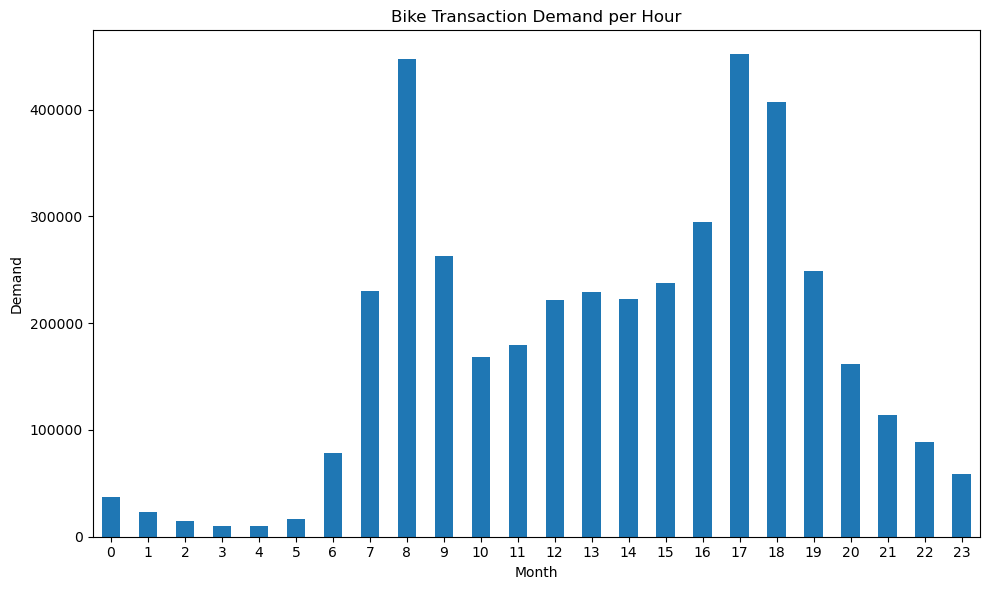

In [55]:
# Group the data by month and count the number of transactions
demand_per_hour = bike_data_2019_months.groupby(bike_data_2019_months['start_hour'])['rental_id'].count()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the bar chart
demand_per_hour.plot(kind='bar')

# Customize the chart
plt.xlabel('Month')
plt.ylabel('Demand')
plt.title('Bike Transaction Demand per Hour')
plt.xticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

In [58]:
# print count per hour for all data
bike_data_2019_months_grouped = bike_data_2019_months.groupby(['start_hour'])['rental_id'].count()
bike_data_2019_months_grouped

start_hour
0      36847
1      23104
2      14570
3      10443
4       9584
5      16904
6      78305
7     229741
8     447594
9     262957
10    167990
11    179216
12    221210
13    229366
14    222237
15    237609
16    294876
17    451601
18    406862
19    248695
20    161271
21    113866
22     88614
23     58674
Name: rental_id, dtype: int64

In [60]:
bike_data[bike_data['bank_holiday'] == 0]

KeyboardInterrupt: 